In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from model import RNN


### Preparation ####

# set random seed
seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

# set precision and device
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

### load dataset ###

inputs_train = np.load('./data/train_data_tensor.npy')
labels_train = np.load('./data/train_labels_tensor.npy')
inputs_test = np.load('./data/test_data_tensor.npy')
labels_test = np.load('./data/test_labels_tensor.npy')

inputs_train = torch.tensor(inputs_train, dtype=torch.float64, requires_grad=True).to(device).unsqueeze(2)
labels_train = torch.tensor(labels_train, dtype=torch.float64, requires_grad=True).to(device).unsqueeze(2)
inputs_test = torch.tensor(inputs_test, dtype=torch.float64, requires_grad=True).to(device).unsqueeze(2)
labels_test = torch.tensor(labels_test, dtype=torch.float64, requires_grad=True).to(device).unsqueeze(2)


def l1(model):
    l1_reg = torch.tensor(0.).to(device)
    for param in model.parameters():
        l1_reg += torch.sum(torch.abs(param))
    return l1_reg

model = RNN(1000, input_dim=1).to(device)


### Training ###

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.00)
steps = 10000
log = 500
lamb = 0e-4


train_accuracies = []
test_accuracies = []

train_losses=[]
test_losses=[]
for step in range(steps):
    
    optimizer.zero_grad()
    
    pred_train = model(inputs_train)
    loss_train = torch.mean((pred_train-labels_train)**2)
    
    acc_train = torch.mean((abs(pred_train - labels_train) < 0.01).long().float())
    pred_test = model(inputs_test)
    loss_test = torch.mean((pred_test-labels_test)**2)
    acc_test = torch.mean((abs(pred_test - labels_test) < 0.01).long().float())
    
    reg = l1(model)
    loss = loss_train + lamb * reg
    
    loss.backward()
    optimizer.step()

    if step % log == 0:
        print("step = %d | train loss: %.2e | test loss %.2e | train acc: %.2e | test acc: %.2e | reg: %.2e "%(step, loss_train.cpu().detach().numpy(), loss_test.cpu().detach().numpy(), acc_train.cpu().detach().numpy(), acc_test.cpu().detach().numpy(), reg.cpu().detach().numpy()))
        train_accuracies.append(acc_train.cpu().detach().numpy())
        test_accuracies.append(acc_test.cpu().detach().numpy())

        train_losses.append(loss_train.cpu().detach().numpy())
        test_losses.append(loss_test.cpu().detach().numpy())
torch.save(model.state_dict(), './model_rnn')

cpu
step = 0 | train loss: 7.83e+02 | test loss 7.68e+02 | train acc: 6.11e-04 | test acc: 7.32e-03 | reg: 1.68e+04 
step = 500 | train loss: 3.13e+02 | test loss 3.63e+02 | train acc: 1.22e-03 | test acc: 3.66e-03 | reg: 7.47e+04 
step = 1000 | train loss: 3.02e+02 | test loss 3.64e+02 | train acc: 3.66e-03 | test acc: 4.88e-03 | reg: 8.48e+04 
step = 1500 | train loss: 2.93e+02 | test loss 3.70e+02 | train acc: 4.27e-03 | test acc: 0.00e+00 | reg: 9.37e+04 
step = 2000 | train loss: 2.86e+02 | test loss 3.77e+02 | train acc: 9.16e-04 | test acc: 2.44e-03 | reg: 1.02e+05 
step = 2500 | train loss: 2.79e+02 | test loss 3.86e+02 | train acc: 2.44e-03 | test acc: 1.22e-03 | reg: 1.10e+05 
step = 3000 | train loss: 2.74e+02 | test loss 3.91e+02 | train acc: 8.85e-03 | test acc: 4.88e-03 | reg: 1.16e+05 
step = 3500 | train loss: 2.75e+02 | test loss 4.01e+02 | train acc: 6.11e-04 | test acc: 0.00e+00 | reg: 1.21e+05 
step = 4000 | train loss: 2.70e+02 | test loss 3.95e+02 | train acc: 9.1

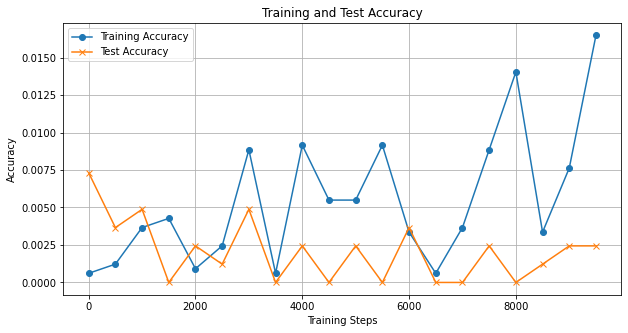

Final test accuracy: 7.89e-01


In [2]:
x_values = range(0, steps, log)

# Plot the training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(x_values[:len(train_accuracies)], train_accuracies, label='Training Accuracy', marker='o')
plt.plot(x_values[:len(test_accuracies)], test_accuracies, label='Test Accuracy', marker='x')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.grid()
plt.show()

# Test the final model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    pred_final_test = model(inputs_test)
    acc_final_test = torch.mean(((pred_final_test - 0.5) * (labels_test - 0.5) > 0).long().float())
    print("Final test accuracy: %.2e" % acc_final_test.cpu().detach().numpy())

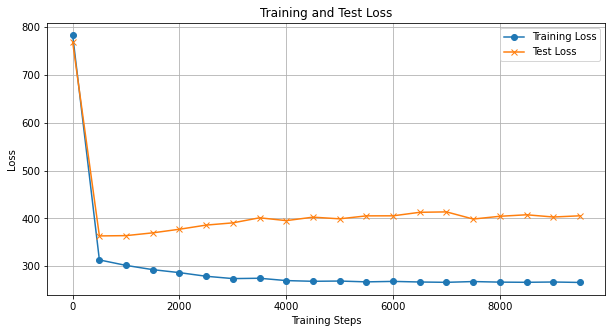

Final test accuracy: 7.89e-01


In [3]:
x_values = range(0, steps, log)

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(x_values[:len(train_losses)], train_losses, label='Training Loss', marker='o')
plt.plot(x_values[:len(test_losses)], test_losses, label='Test Loss', marker='x')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.grid()
plt.show()

# Test the final model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    pred_final_test = model(inputs_test)
    acc_final_test = torch.mean(((pred_final_test - 0.5) * (labels_test - 0.5) > 0).long().float())
    print("Final test accuracy: %.2e" % acc_final_test.cpu().detach().numpy())

In [10]:
# model.eval()
# with torch.no_grad():
#     pred_final_test = model(inputs_test)
#     plt.scatter(inputs_test.detach().numpy().squeeze(),pred_final_test.detach().numpy().squeeze())
#     x = np.linspace(1,2*np.pi, 100)
#     plt.plot(x, np.sin(x), label="True Curve", color='r')
#     plt.legend()
#     plt.show()
    